# ML with Spark
- Prepared by: Van Julius Leander G. Lopez
- Altered by: Ma. Addine Anne T. Carreon

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from numpy.testing import assert_equal, assert_allclose

os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

spark = (
    SparkSession
        .builder
        .master('local[*]')
        .getOrCreate()
)

To introduce MLlib, let us try performing a simple task which is taking the Spearman correlation of vectors.

In [2]:
# Import the Vectors class for creating dense and sparse vectors
from pyspark.ml.linalg import Vectors

# Import the Correlation class for computing correlation matrices
from pyspark.ml.stat import Correlation

In [3]:
data = [
    (Vectors.sparse(4, [(0, 1.0), (3, -2.0)]),),
    (Vectors.dense([4.0, 5.0, 0.0, 3.0]),),
    (Vectors.sparse(4, [(0, 9.0), (3, 1.0)]),)
]

df = spark.createDataFrame(data, ["features"])

df.show()

+--------------------+
|            features|
+--------------------+
|(4,[0,3],[1.0,-2.0])|
|   [4.0,5.0,0.0,3.0]|
| (4,[0,3],[9.0,1.0])|
+--------------------+



In [4]:
correlation_matrix = Correlation.corr(df, "features", "pearson").head()[0]
print(correlation_matrix)

DenseMatrix([[ 1.        , -0.14285714,         nan,  0.47521831],
             [-0.14285714,  1.        ,         nan,  0.80295507],
             [        nan,         nan,  1.        ,         nan],
             [ 0.47521831,  0.80295507,         nan,  1.        ]])


Notice that each row can be a sparse or dense vector, and that all rows need not be of the same kind of vector. Correlation is done on the matrix formed by the dataframe column `features`. That is, correlation is performed on the matrix:

$$
\left(
\begin{array}{cccc}
1 & 0 & 0 & -2 \\
4 & 5 & 0 & 3 \\
9 & 0 & 0 & 1
\end{array}
\right)
$$

The vectors are the columns of this matrix, thus, the resulting correlation matrix is $4 \times 4$.

## Transformers and Estimators
***

Apache Spark also has the notion of transformers and estimators. As in scikit-learn, transformers accept a dataframe and return a dataframe. On the other hand, unlike in scikit-learn, estimators accept a dataframe and returns a transformer. In general, the `fit` function does not return the same transformer or estimator but a trained model or transformer. You will then use its `transform` method to transform an input dataset or make predictions. There is no `predict` or `fit_predict` methods. 

Prediction is done using a `transform` call. It will return a dataframe with an additional column holding the predictions. Typical parameters of transformers and estimators are `inputCol` or `inputCols` and `outputCol`. If it's an `inputCol` then it usually expects that `inputCol` to contain a `Vector` corresponding to the different column values for that row.

## Feature Engineering
***

Let us look at how to do feature engineering on SparkML. As an example, let's convert `PULocationID` into an integer.

In [5]:
# Import classes for defining the schema of a DataFrame.
from pyspark.sql.types import StructType, StructField, IntegerType, DoubleType

In [6]:
schema = StructType([
    StructField("StudentID", IntegerType(), nullable=False),
    StructField("Age", IntegerType(), nullable=False),
    StructField("Gender", IntegerType(), nullable=False),
    StructField("Ethnicity", IntegerType(), nullable=False),
    StructField("ParentalEducation", IntegerType(), nullable=False),
    StructField("StudyTimeWeekly", DoubleType(), nullable=False),
    StructField("Absences", IntegerType(), nullable=False),
    StructField("Tutoring", IntegerType(), nullable=False),
    StructField("ParentalSupport", IntegerType(), nullable=False),
    StructField("Extracurricular", IntegerType(), nullable=False),
    StructField("Sports", IntegerType(), nullable=False),
    StructField("Music", IntegerType(), nullable=False),
    StructField("Volunteering", IntegerType(), nullable=False),
    StructField("GPA", DoubleType(), nullable=False),
    StructField("GradeClass", DoubleType(), nullable=False)
])

student_performance_df = spark.read.csv(
    'Student_performance_data.csv',
    sep=',', header=True, schema=schema
)

In [7]:
student_performance_df.printSchema()

root
 |-- StudentID: integer (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Gender: integer (nullable = true)
 |-- Ethnicity: integer (nullable = true)
 |-- ParentalEducation: integer (nullable = true)
 |-- StudyTimeWeekly: double (nullable = true)
 |-- Absences: integer (nullable = true)
 |-- Tutoring: integer (nullable = true)
 |-- ParentalSupport: integer (nullable = true)
 |-- Extracurricular: integer (nullable = true)
 |-- Sports: integer (nullable = true)
 |-- Music: integer (nullable = true)
 |-- Volunteering: integer (nullable = true)
 |-- GPA: double (nullable = true)
 |-- GradeClass: double (nullable = true)



Since we want to perform classificattion on the dataset with `GradeClass` as the target variable, we want to convert it to integer type. We can do that by casting it with the integer type.

In [8]:
(student_performance_df
 .withColumn('GradeClass_Target', student_performance_df.GradeClass.astype('integer'))
 .limit(10)
 .toPandas())

,StudentID,Age,Gender,Ethnicity,ParentalEducation,StudyTimeWeekly,Absences,Tutoring,ParentalSupport,Extracurricular,Sports,Music,Volunteering,GPA,GradeClass,GradeClass_Target
0,1001,17,1,0,2,19.833723,7,1,2,0,0,1,0,2.929196,2.0,2
1,1002,18,0,0,1,15.408756,0,0,1,0,0,0,0,3.042915,1.0,1
2,1003,15,0,2,3,4.210570,26,0,2,0,0,0,0,0.112602,4.0,4
3,1004,17,1,0,3,10.028829,14,0,3,1,0,0,0,2.054218,3.0,3
4,1005,17,1,0,2,4.672495,17,1,3,0,0,0,0,1.288061,4.0,4
5,1006,18,0,0,1,8.191219,0,0,1,1,0,0,0,3.084184,1.0,1
6,1007,15,0,1,1,15.601680,10,0,3,0,1,0,0,2.748237,2.0,2
7,1008,15,1,1,4,15.424496,22,1,1,1,0,0,0,1.360143,4.0,4
8,1009,17,0,0,0,4.562008,1,0,2,0,1,0,1,2.896819,2.0,2
9,1010,16,1,0,1,18.444466,0,0,3,1,0,0,0,3.573474,0.0,0


In [9]:
(student_performance_df
 .withColumn('GradeClass_Target', student_performance_df.GradeClass.astype('integer'))
 .printSchema())

root
 |-- StudentID: integer (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Gender: integer (nullable = true)
 |-- Ethnicity: integer (nullable = true)
 |-- ParentalEducation: integer (nullable = true)
 |-- StudyTimeWeekly: double (nullable = true)
 |-- Absences: integer (nullable = true)
 |-- Tutoring: integer (nullable = true)
 |-- ParentalSupport: integer (nullable = true)
 |-- Extracurricular: integer (nullable = true)
 |-- Sports: integer (nullable = true)
 |-- Music: integer (nullable = true)
 |-- Volunteering: integer (nullable = true)
 |-- GPA: double (nullable = true)
 |-- GradeClass: double (nullable = true)
 |-- GradeClass_Target: integer (nullable = true)



In [10]:
student_performance_df = (
    student_performance_df
    .withColumn('GradeClass_Target', student_performance_df.GradeClass.astype('integer'))
)

student_performance_df = student_performance_df.drop("GradeClass")

In [11]:
student_performance_df.limit(10).toPandas()

,StudentID,Age,Gender,Ethnicity,ParentalEducation,StudyTimeWeekly,Absences,Tutoring,ParentalSupport,Extracurricular,Sports,Music,Volunteering,GPA,GradeClass_Target
0,1001,17,1,0,2,19.833723,7,1,2,0,0,1,0,2.929196,2
1,1002,18,0,0,1,15.408756,0,0,1,0,0,0,0,3.042915,1
2,1003,15,0,2,3,4.210570,26,0,2,0,0,0,0,0.112602,4
3,1004,17,1,0,3,10.028829,14,0,3,1,0,0,0,2.054218,3
4,1005,17,1,0,2,4.672495,17,1,3,0,0,0,0,1.288061,4
5,1006,18,0,0,1,8.191219,0,0,1,1,0,0,0,3.084184,1
6,1007,15,0,1,1,15.601680,10,0,3,0,1,0,0,2.748237,2
7,1008,15,1,1,4,15.424496,22,1,1,1,0,0,0,1.360143,4
8,1009,17,0,0,0,4.562008,1,0,2,0,1,0,1,2.896819,2
9,1010,16,1,0,1,18.444466,0,0,3,1,0,0,0,3.573474,0


## String Indexer and OneHot Encoder
***

To show how a string indexer works and perform one hot encoder, we will be using the financial_pop dataset.

In [12]:
finpop_df = spark.read.csv(
    'financial_pop.csv',
    sep=',', header=True
)

In [13]:
finpop_df.printSchema()

root
 |-- pop: string (nullable = true)
 |-- tot_local_sources: string (nullable = true)
 |-- tot_tax_revenue: string (nullable = true)
 |-- tot_current_oper_income: string (nullable = true)
 |-- total_oper_expenses: string (nullable = true)
 |-- net_oper_income: string (nullable = true)
 |-- total_non_income_receipts: string (nullable = true)
 |-- capital_expenditure: string (nullable = true)
 |-- total_non_oper_expenditures: string (nullable = true)
 |-- cash_balance_end: string (nullable = true)
 |-- shp_province: string (nullable = true)
 |-- shp_municipality: string (nullable = true)



In [14]:
finpop_df.limit(5).toPandas()

,pop,tot_local_sources,tot_tax_revenue,tot_current_oper_income,total_oper_expenses,net_oper_income,total_non_income_receipts,capital_expenditure,total_non_oper_expenditures,cash_balance_end,shp_province,shp_municipality
0,48163,74.04592008,36.55629364,230.5770761,206.8487167,23.72835939,0,16.202464,21.18111613,15.7586811,Abra,Bangued
1,3573,0.11566694,0.03563294,56.68988294,54.40990988,2.27997306,0,0,0.03,20.36974271,Abra,Boliney
2,17115,1.73641072,1.01956488,93.64724172,66.22238864,27.42485308,0,19.56003415,20.79218215,6.63267093,Abra,Bucay
3,2501,0.27368935,0.12915035,44.78910413,29.63318092,15.15592321,0,0.479569,0.656569,24.34835602,Abra,Bucloc
4,2088,0.64380135,0.27765989,51.24232235,47.84848631,3.39383604,0,0,0,6.51157536,Abra,Daguioman


Here we have `shp_province` as a sample string column.

In [15]:
# Import the StringIndexer class for converting categorical strings into numerical indices.
from pyspark.ml.feature import StringIndexer

In [16]:
si_province = StringIndexer(inputCol='shp_province', outputCol='shp_province_index')
si_province_trained = si_province.fit(finpop_df)

Notice that there's no such thing as `si_province.fit_transform` or `si_province.fit_predict`. The `fit` method returns a model which is a different class from `si_province`.

In [17]:
type(si_province_trained)

pyspark.ml.feature.StringIndexerModel

We use the model to transform the `inputCol` in the input dataset into a new column `outputCol` in the same dataset.

In [18]:
finpop_df = si_province_trained.transform(finpop_df)

In [19]:
finpop_df.limit(5).toPandas()

,pop,tot_local_sources,tot_tax_revenue,tot_current_oper_income,total_oper_expenses,net_oper_income,total_non_income_receipts,capital_expenditure,total_non_oper_expenditures,cash_balance_end,shp_province,shp_municipality,shp_province_index
0,48163,74.04592008,36.55629364,230.5770761,206.8487167,23.72835939,0,16.202464,21.18111613,15.7586811,Abra,Bangued,16.0
1,3573,0.11566694,0.03563294,56.68988294,54.40990988,2.27997306,0,0,0.03,20.36974271,Abra,Boliney,16.0
2,17115,1.73641072,1.01956488,93.64724172,66.22238864,27.42485308,0,19.56003415,20.79218215,6.63267093,Abra,Bucay,16.0
3,2501,0.27368935,0.12915035,44.78910413,29.63318092,15.15592321,0,0.479569,0.656569,24.34835602,Abra,Bucloc,16.0
4,2088,0.64380135,0.27765989,51.24232235,47.84848631,3.39383604,0,0,0,6.51157536,Abra,Daguioman,16.0


We can perform one-hot encoding using `OneHotEncoder` but it only accepts categorical indices not strings directly. Hence, the need for `StringIndexer` and not just conversion to a `double` type.

In [20]:
# Import the OneHotEncoder class for converting categorical indices into one-hot encoded vectors.
from pyspark.ml.feature import OneHotEncoder

In [21]:
ohe_province = OneHotEncoder(
    inputCol='shp_province_index', outputCol='shp_province_ohe')
ohe_province_trained = ohe_province.fit(finpop_df)

In [22]:
(ohe_province_trained
 .transform(finpop_df)
 .limit(5)
 .toPandas())

,pop,tot_local_sources,tot_tax_revenue,tot_current_oper_income,total_oper_expenses,net_oper_income,total_non_income_receipts,capital_expenditure,total_non_oper_expenditures,cash_balance_end,shp_province,shp_municipality,shp_province_index,shp_province_ohe
0,48163,74.04592008,36.55629364,230.5770761,206.8487167,23.72835939,0,16.202464,21.18111613,15.7586811,Abra,Bangued,16.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,3573,0.11566694,0.03563294,56.68988294,54.40990988,2.27997306,0,0,0.03,20.36974271,Abra,Boliney,16.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,17115,1.73641072,1.01956488,93.64724172,66.22238864,27.42485308,0,19.56003415,20.79218215,6.63267093,Abra,Bucay,16.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,2501,0.27368935,0.12915035,44.78910413,29.63318092,15.15592321,0,0.479569,0.656569,24.34835602,Abra,Bucloc,16.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,2088,0.64380135,0.27765989,51.24232235,47.84848631,3.39383604,0,0,0,6.51157536,Abra,Daguioman,16.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


`OneHotIndexer` generates a sparse vector.

In [23]:
ohe_province_trained.transform(finpop_df).printSchema()

root
 |-- pop: string (nullable = true)
 |-- tot_local_sources: string (nullable = true)
 |-- tot_tax_revenue: string (nullable = true)
 |-- tot_current_oper_income: string (nullable = true)
 |-- total_oper_expenses: string (nullable = true)
 |-- net_oper_income: string (nullable = true)
 |-- total_non_income_receipts: string (nullable = true)
 |-- capital_expenditure: string (nullable = true)
 |-- total_non_oper_expenditures: string (nullable = true)
 |-- cash_balance_end: string (nullable = true)
 |-- shp_province: string (nullable = true)
 |-- shp_municipality: string (nullable = true)
 |-- shp_province_index: double (nullable = false)
 |-- shp_province_ohe: vector (nullable = true)



For many SparkML models, the input is just a single column of vector. To create a vector from several columns of numeric variables, we can use `VectorAssembler`. Let's go back to our initial dataset, student performance, for this example.

In [24]:
# Import the VectorAssembler class for combining multiple feature columns into a single vector column.
from pyspark.ml.feature import VectorAssembler

In [25]:
(VectorAssembler(inputCols=['Gender', 'StudyTimeWeekly','Absences'],
                     outputCol='features')
.transform(student_performance_df)
.printSchema())

root
 |-- StudentID: integer (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Gender: integer (nullable = true)
 |-- Ethnicity: integer (nullable = true)
 |-- ParentalEducation: integer (nullable = true)
 |-- StudyTimeWeekly: double (nullable = true)
 |-- Absences: integer (nullable = true)
 |-- Tutoring: integer (nullable = true)
 |-- ParentalSupport: integer (nullable = true)
 |-- Extracurricular: integer (nullable = true)
 |-- Sports: integer (nullable = true)
 |-- Music: integer (nullable = true)
 |-- Volunteering: integer (nullable = true)
 |-- GPA: double (nullable = true)
 |-- GradeClass_Target: integer (nullable = true)
 |-- features: vector (nullable = true)



In [26]:
(VectorAssembler(inputCols=['Gender', 'StudyTimeWeekly','Absences'],
                     outputCol='features')
.transform(student_performance_df)
 .limit(5)
.toPandas())

,StudentID,Age,Gender,Ethnicity,ParentalEducation,StudyTimeWeekly,Absences,Tutoring,ParentalSupport,Extracurricular,Sports,Music,Volunteering,GPA,GradeClass_Target,features
0,1001,17,1,0,2,19.833723,7,1,2,0,0,1,0,2.929196,2,"[1.0, 19.8337228078547, 7.0]"
1,1002,18,0,0,1,15.408756,0,0,1,0,0,0,0,3.042915,1,"[0.0, 15.4087560558467, 0.0]"
2,1003,15,0,2,3,4.210570,26,0,2,0,0,0,0,0.112602,4,"[0.0, 4.21056976881226, 26.0]"
3,1004,17,1,0,3,10.028829,14,0,3,1,0,0,0,2.054218,3,"[1.0, 10.0288294739582, 14.0]"
4,1005,17,1,0,2,4.672495,17,1,3,0,0,0,0,1.288061,4,"[1.0, 4.67249527297133, 17.0]"


Individual elements of vectors can be converted into categorical indices using `VectorIndexer`. A vector element will be considered a categorical variable if the number of unique values for that element does not exceed `maxCategories`.

In [27]:
student_performance_df_vec = (
    VectorAssembler(inputCols=['Gender', 'StudyTimeWeekly','Absences'],
                    outputCol='features')
    .transform(student_performance_df)
)

In [28]:
# Import the VectorIndexer class for indexing categorical features within a vector column.
from pyspark.ml.feature import VectorIndexer

In [29]:
vi = VectorIndexer(maxCategories=4, 
                   inputCol='features', 
                   outputCol='features_indexed')
vi_trained = vi.fit(student_performance_df_vec)
student_performance_df_vec = vi_trained.transform(student_performance_df_vec)

In [30]:
student_performance_df_vec.limit(5).toPandas()

,StudentID,Age,Gender,Ethnicity,ParentalEducation,StudyTimeWeekly,Absences,Tutoring,ParentalSupport,Extracurricular,Sports,Music,Volunteering,GPA,GradeClass_Target,features,features_indexed
0,1001,17,1,0,2,19.833723,7,1,2,0,0,1,0,2.929196,2,"[1.0, 19.8337228078547, 7.0]","[1.0, 19.8337228078547, 7.0]"
1,1002,18,0,0,1,15.408756,0,0,1,0,0,0,0,3.042915,1,"[0.0, 15.4087560558467, 0.0]","[0.0, 15.4087560558467, 0.0]"
2,1003,15,0,2,3,4.210570,26,0,2,0,0,0,0,0.112602,4,"[0.0, 4.21056976881226, 26.0]","[0.0, 4.21056976881226, 26.0]"
3,1004,17,1,0,3,10.028829,14,0,3,1,0,0,0,2.054218,3,"[1.0, 10.0288294739582, 14.0]","[1.0, 10.0288294739582, 14.0]"
4,1005,17,1,0,2,4.672495,17,1,3,0,0,0,0,1.288061,4,"[1.0, 4.67249527297133, 17.0]","[1.0, 4.67249527297133, 17.0]"


In [31]:
student_performance_df_vec.printSchema()

root
 |-- StudentID: integer (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Gender: integer (nullable = true)
 |-- Ethnicity: integer (nullable = true)
 |-- ParentalEducation: integer (nullable = true)
 |-- StudyTimeWeekly: double (nullable = true)
 |-- Absences: integer (nullable = true)
 |-- Tutoring: integer (nullable = true)
 |-- ParentalSupport: integer (nullable = true)
 |-- Extracurricular: integer (nullable = true)
 |-- Sports: integer (nullable = true)
 |-- Music: integer (nullable = true)
 |-- Volunteering: integer (nullable = true)
 |-- GPA: double (nullable = true)
 |-- GradeClass_Target: integer (nullable = true)
 |-- features: vector (nullable = true)
 |-- features_indexed: vector (nullable = true)



## Classification and Regression
***

Just like in scikit-learn, in MLlib, we instantiate an ML model, fit data on it then use the trained data to predict. Data splitting is done using `randomSplit` and prediction is via the `transform` method of the trained model. Although setting the seed will result in the same splitting, it is dependent on the partitions. Thus, it is recommended to save the split data frames to persistent storage to guarantee reproducibility.

In [32]:
student_performance_df.printSchema()

root
 |-- StudentID: integer (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Gender: integer (nullable = true)
 |-- Ethnicity: integer (nullable = true)
 |-- ParentalEducation: integer (nullable = true)
 |-- StudyTimeWeekly: double (nullable = true)
 |-- Absences: integer (nullable = true)
 |-- Tutoring: integer (nullable = true)
 |-- ParentalSupport: integer (nullable = true)
 |-- Extracurricular: integer (nullable = true)
 |-- Sports: integer (nullable = true)
 |-- Music: integer (nullable = true)
 |-- Volunteering: integer (nullable = true)
 |-- GPA: double (nullable = true)
 |-- GradeClass_Target: integer (nullable = true)



In [33]:
feat_list = student_performance_df.columns

feat_list.remove('StudentID')
feat_list.remove('GradeClass_Target')

In [34]:
# Import the RFC class for building and training a random forest model for classification tasks.
from pyspark.ml.classification import RandomForestClassifier

In [35]:
df_training, df_test = student_performance_df.randomSplit([0.7, 0.3], seed=143)
df_training.cache()
df_test.cache()

assembler = VectorAssembler(inputCols=feat_list, outputCol='features')
df_training = assembler.transform(df_training)
df_test = assembler.transform(df_test)

In [36]:
df_training.limit(5).toPandas()

,StudentID,Age,Gender,Ethnicity,ParentalEducation,StudyTimeWeekly,Absences,Tutoring,ParentalSupport,Extracurricular,Sports,Music,Volunteering,GPA,GradeClass_Target,features
0,1003,15,0,2,3,4.210570,26,0,2,0,0,0,0,0.112602,4,"(15.0, 0.0, 2.0, 3.0, 4.21056976881226, 26.0, ..."
1,1004,17,1,0,3,10.028829,14,0,3,1,0,0,0,2.054218,3,"[17.0, 1.0, 0.0, 3.0, 10.0288294739582, 14.0, ..."
2,1005,17,1,0,2,4.672495,17,1,3,0,0,0,0,1.288061,4,"[17.0, 1.0, 0.0, 2.0, 4.67249527297133, 17.0, ..."
3,1009,17,0,0,0,4.562008,1,0,2,0,1,0,1,2.896819,2,"(17.0, 0.0, 0.0, 0.0, 4.5620075580477, 1.0, 0...."
4,1011,17,0,0,1,11.851364,11,0,1,0,0,0,0,2.147172,3,"(17.0, 0.0, 0.0, 1.0, 11.8513636552965, 11.0, ..."


In [37]:
vi = VectorIndexer(maxCategories=2, 
                   inputCol='features', 
                   outputCol='features_indexed')

vi_trained = vi.fit(df_training)

student_performance_df_train = vi_trained.transform(df_training)
student_performance_df_test = vi_trained.transform(df_test)

In [38]:
student_performance_df_train.limit(5).toPandas()

,StudentID,Age,Gender,Ethnicity,ParentalEducation,StudyTimeWeekly,Absences,Tutoring,ParentalSupport,Extracurricular,Sports,Music,Volunteering,GPA,GradeClass_Target,features,features_indexed
0,1003,15,0,2,3,4.210570,26,0,2,0,0,0,0,0.112602,4,"(15.0, 0.0, 2.0, 3.0, 4.21056976881226, 26.0, ...","(15.0, 0.0, 2.0, 3.0, 4.21056976881226, 26.0, ..."
1,1004,17,1,0,3,10.028829,14,0,3,1,0,0,0,2.054218,3,"[17.0, 1.0, 0.0, 3.0, 10.0288294739582, 14.0, ...","[17.0, 1.0, 0.0, 3.0, 10.0288294739582, 14.0, ..."
2,1005,17,1,0,2,4.672495,17,1,3,0,0,0,0,1.288061,4,"[17.0, 1.0, 0.0, 2.0, 4.67249527297133, 17.0, ...","[17.0, 1.0, 0.0, 2.0, 4.67249527297133, 17.0, ..."
3,1009,17,0,0,0,4.562008,1,0,2,0,1,0,1,2.896819,2,"(17.0, 0.0, 0.0, 0.0, 4.5620075580477, 1.0, 0....","(17.0, 0.0, 0.0, 0.0, 4.5620075580477, 1.0, 0...."
4,1011,17,0,0,1,11.851364,11,0,1,0,0,0,0,2.147172,3,"(17.0, 0.0, 0.0, 1.0, 11.8513636552965, 11.0, ...","(17.0, 0.0, 0.0, 1.0, 11.8513636552965, 11.0, ..."


In [39]:
rf = RandomForestClassifier(featuresCol='features_indexed', labelCol='GradeClass_Target', maxBins=1000)

rf_trained = rf.fit(student_performance_df_train)

df_predict_train = rf_trained.transform(student_performance_df_train)
df_predict_test = rf_trained.transform(student_performance_df_test)

In [40]:
feature_significance = rf_trained.featureImportances.toArray()
feature_names = feat_list

signi_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_significance
}).sort_values(by='Importance', ascending=False)

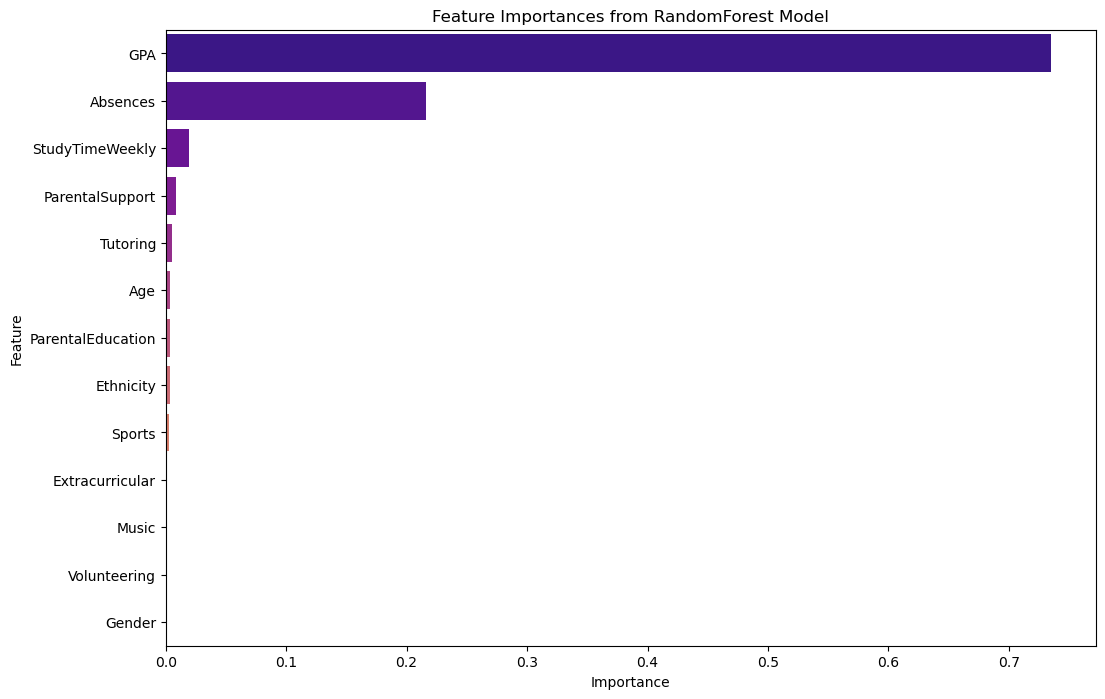

In [41]:
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=signi_df, palette='plasma')
plt.title('Feature Importances from RandomForest Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

The graph shows which factors are most important in predicting student performance using a RandomForest model. It turns out that a **student's GPA is the most important factor by a large margin, meaning it has the biggest influence on how the model makes its predictions**. The number of absences a student has is also important but not as much as GPA. After that, the amount of time a student spends studying each week is the next most important factor, although it has a much smaller impact. Other factors like parental support, tutoring, and sports have some influence but are less significant, while gender, volunteering, and music have minimal impact on the model's predictions.

In [42]:
df_predict_train.select('features', 'GradeClass_Target', 'prediction').show()

+--------------------+-----------------+----------+
|            features|GradeClass_Target|prediction|
+--------------------+-----------------+----------+
|(13,[0,2,3,4,5,7,...|                4|       4.0|
|[17.0,1.0,0.0,3.0...|                3|       3.0|
|[17.0,1.0,0.0,2.0...|                4|       4.0|
|(13,[0,4,5,7,9,11...|                2|       2.0|
|(13,[0,3,4,5,7,12...|                3|       3.0|
|(13,[0,3,4,5,7,11...|                4|       4.0|
|[17.0,0.0,1.0,1.0...|                4|       4.0|
|[18.0,1.0,0.0,1.0...|                3|       3.0|
|[18.0,0.0,3.0,1.0...|                3|       3.0|
|(13,[0,1,4,5,6,7,...|                4|       4.0|
|[18.0,0.0,1.0,3.0...|                4|       4.0|
|(13,[0,3,4,5,7,10...|                3|       3.0|
|[16.0,1.0,1.0,0.0...|                4|       4.0|
|(13,[0,1,3,4,5,7,...|                4|       4.0|
|[16.0,1.0,0.0,3.0...|                2|       2.0|
|(13,[0,3,4,5,7,9,...|                2|       2.0|
|[16.0,1.0,0

In [43]:
df_predict_test.select('features', 'GradeClass_Target', 'prediction').show()

+--------------------+-----------------+----------+
|            features|GradeClass_Target|prediction|
+--------------------+-----------------+----------+
|[17.0,1.0,0.0,2.0...|                2|       2.0|
|(13,[0,3,4,7,12],...|                1|       1.0|
|(13,[0,3,4,7,8,12...|                1|       1.0|
|[15.0,0.0,1.0,1.0...|                2|       2.0|
|[15.0,1.0,1.0,4.0...|                4|       4.0|
|(13,[0,1,3,4,7,8,...|                0|       1.0|
|[17.0,0.0,1.0,2.0...|                4|       4.0|
|(13,[0,3,4,5,6,9,...|                4|       4.0|
|[16.0,1.0,0.0,3.0...|                2|       2.0|
|(13,[0,3,4,5,7,8,...|                4|       4.0|
|[18.0,1.0,3.0,4.0...|                4|       4.0|
|(13,[0,3,4,5,7,8,...|                4|       4.0|
|[15.0,0.0,2.0,2.0...|                4|       4.0|
|[16.0,0.0,0.0,3.0...|                4|       4.0|
|[17.0,1.0,2.0,1.0...|                4|       4.0|
|(13,[0,3,4,5,7,10...|                2|       2.0|
|[16.0,0.0,1

In [44]:
# Import the MCE class for evaluating classification models based on metrics like accuracy.
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Import the MM class for evaluating classification metrics from RDD-based predictions.
from pyspark.mllib.evaluation import MulticlassMetrics

# Import the col function for referencing column names in DataFrame operations.
from pyspark.sql.functions import col

In [45]:
df_predict_train = df_predict_train.select(col('GradeClass_Target').alias('label'), 'prediction')
df_predict_test = df_predict_test.select(col('GradeClass_Target').alias('label'), 'prediction')

evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')
accuracy_train = evaluator.evaluate(df_predict_train)
accuracy_test = evaluator.evaluate(df_predict_test)

print(f'Training Accuracy: {accuracy_train}')
print(f'Test Accuracy: {accuracy_test}')

Training Accuracy: 0.9049881235154394
Test Accuracy: 0.8968926553672316


The model achieved **high accuracy on both the training and test datasets, indicating good performance in predicting the students' grade classes**. The slight decrease in accuracy from training to test data suggests that the model generalizes well but might have minor overfitting.

In [46]:
# Import metrics for evaluating classification models.
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

In [47]:
pd_predict_train = df_predict_train.toPandas()
pd_predict_test = df_predict_test.toPandas()

def compute_metrics(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    
    return cm, accuracy, precision, recall, f1

cm_train, accuracy_train, precision_train, recall_train, f1_score_train = compute_metrics(pd_predict_train['label'], pd_predict_train['prediction'])
print(f'Training Confusion Matrix:\n{cm_train}')
print(f'Training Accuracy: {accuracy_train}')
print(f'Training Precision: {precision_train}')
print(f'Training Recall: {recall_train}')
print(f'Training F1 Score: {f1_score_train}')

cm_test, accuracy_test, precision_test, recall_test, f1_score_test = compute_metrics(pd_predict_test['label'], pd_predict_test['prediction'])
print(f'Test Confusion Matrix:\n{cm_test}')
print(f'Test Accuracy: {accuracy_test}')
print(f'Test Precision: {precision_test}')
print(f'Test Recall: {recall_test}')
print(f'Test F1 Score: {f1_score_test}')

Training Confusion Matrix:
[[  5  46   6   6  10]
 [  0 166   1   7  16]
 [  0   3 252   9  11]
 [  0   5   6 256  17]
 [  0   5   3   9 845]]
Training Accuracy: 0.9049881235154394
Training Precision: 0.9117021250310686
Training Recall: 0.9049881235154394
Training F1 Score: 0.8898506338527007
Test Confusion Matrix:
[[  0  20   5   3   6]
 [  0  65   2   0  12]
 [  0   2 108   0   6]
 [  0   3   1 119   7]
 [  0   0   2   4 343]]
Test Accuracy: 0.8968926553672316
Test Precision: 0.8560381601301215
Test Recall: 0.8968926553672316
Test F1 Score: 0.8754876053085645


In [48]:
def plot_confusion_matrix(cm, labels, title):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='BuPu', xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

cm_train = compute_metrics(pd_predict_train['label'], pd_predict_train['prediction'])[0]
cm_test = compute_metrics(pd_predict_test['label'], pd_predict_test['prediction'])[0]
labels = list(range(len(cm_train)))

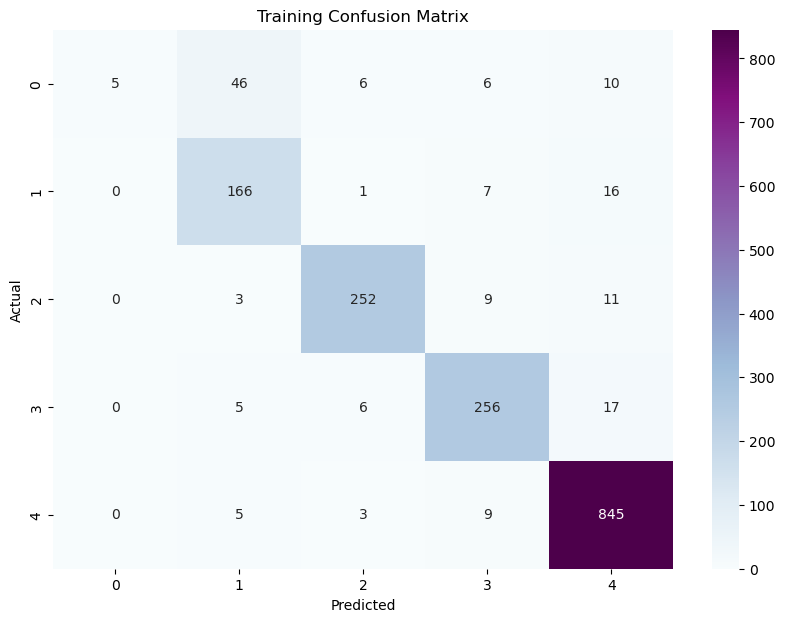

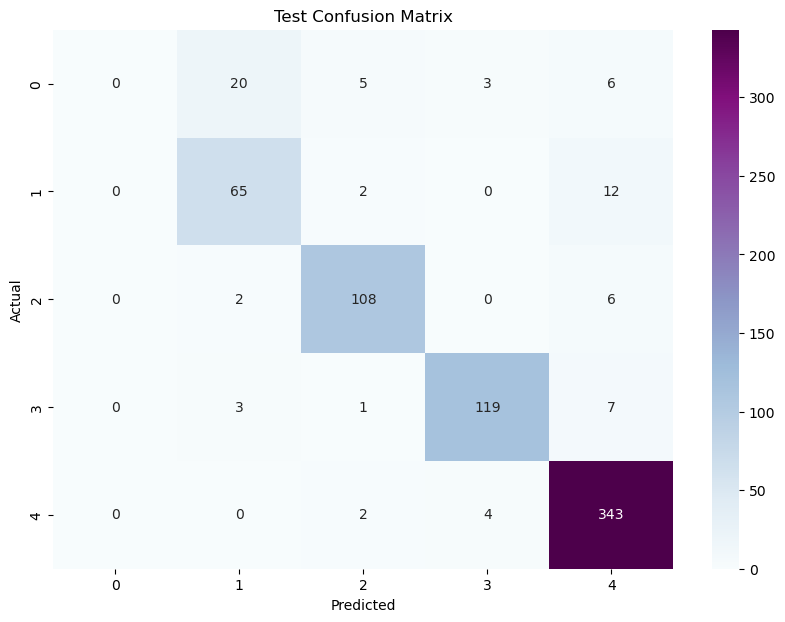

In [49]:
plot_confusion_matrix(cm_train, labels, 'Training Confusion Matrix')
plot_confusion_matrix(cm_test, labels, 'Test Confusion Matrix')

The **model performs well in both training and testing, accurately predicting most classes**. On the training data, the model is especially good at identifying classes 2 and 4, with some confusion in classes 0 and 1. On the test data, the model's performance is still strong, though it struggles a bit more with classes 0 and 1 compared to the training data. Overall, the model is accurate and precise, but there is still some room for improvement in distinguishing certain classes. The slight drop in performance on new data suggests that while the model works well, it could be fine-tuned for even better results.

## Pipelines
***

As you may have noticed, instantiating an estimator or transformer, fitting it to the data then storing its result, then using that to transform the input is quite tedious. In scikit-learn, a way for simplifying this process is to create a `Pipeline`, which Spark also has.

In [50]:
# Import the Pipeline class for constructing and managing machine learning workflows.
from pyspark.ml import Pipeline

In [51]:
df_training, df_test = student_performance_df.randomSplit([0.7, 0.3], seed=143)
df_training.cache()
df_test.cache()

pipe = Pipeline(stages=[
    VectorAssembler(inputCols=feat_list,
                    outputCol='features'),
    VectorIndexer(maxCategories=2, inputCol='features', outputCol='features_indexed'),
    RandomForestClassifier(featuresCol='features_indexed',
                          labelCol='GradeClass_Target',
                          maxBins=1000)
])

model_trained = pipe.fit(df_training)
df_predict = model_trained.transform(df_test)

df_predict[['features', 'GradeClass_Target', 'prediction']].show()

+--------------------+-----------------+----------+
|            features|GradeClass_Target|prediction|
+--------------------+-----------------+----------+
|[17.0,1.0,0.0,2.0...|                2|       2.0|
|(13,[0,3,4,7,12],...|                1|       1.0|
|(13,[0,3,4,7,8,12...|                1|       1.0|
|[15.0,0.0,1.0,1.0...|                2|       2.0|
|[15.0,1.0,1.0,4.0...|                4|       4.0|
|(13,[0,1,3,4,7,8,...|                0|       1.0|
|[17.0,0.0,1.0,2.0...|                4|       4.0|
|(13,[0,3,4,5,6,9,...|                4|       4.0|
|[16.0,1.0,0.0,3.0...|                2|       2.0|
|(13,[0,3,4,5,7,8,...|                4|       4.0|
|[18.0,1.0,3.0,4.0...|                4|       4.0|
|(13,[0,3,4,5,7,8,...|                4|       4.0|
|[15.0,0.0,2.0,2.0...|                4|       4.0|
|[16.0,0.0,0.0,3.0...|                4|       4.0|
|[17.0,1.0,2.0,1.0...|                4|       4.0|
|(13,[0,3,4,5,7,10...|                2|       2.0|
|[16.0,0.0,1

In [52]:
df_predict = df_predict.select(col('GradeClass_Target').alias('label'), 'prediction')

evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')
accuracy_test = evaluator.evaluate(df_predict)

print(f'Test Accuracy: {accuracy_test}')

Test Accuracy: 0.8968926553672316


The resulting test accuracy is consistent with previous results, demonstrating that **the pipeline-based approach performs well and maintains accuracy.**

## Clustering
***

MLlib has a few models for clustering as well.

In [53]:
# Import the KMeans class for clustering data using the K-means algorithm.
from pyspark.ml.clustering import KMeans

# Import the CE class for evaluating clustering results based on metrics like Silhouette score.
from pyspark.ml.evaluation import ClusteringEvaluator

In [54]:
pipe = Pipeline(stages=[
    VectorAssembler(inputCols=feat_list,
                    outputCol='features'),
    VectorIndexer(maxCategories=2, inputCol='features', outputCol='features_indexed'),
    KMeans(k=8)
])

model_trained = pipe.fit(student_performance_df)
df_predict = model_trained.transform(student_performance_df)

evaluator = ClusteringEvaluator()

print('Silhouette score: ', evaluator.evaluate(df_predict))

df_predict[['features', 'prediction']].show()

Silhouette score:  0.43030823316119515
+--------------------+----------+
|            features|prediction|
+--------------------+----------+
|[17.0,1.0,0.0,2.0...|         2|
|(13,[0,3,4,7,12],...|         2|
|(13,[0,2,3,4,5,7,...|         1|
|[17.0,1.0,0.0,3.0...|         0|
|[17.0,1.0,0.0,2.0...|         0|
|(13,[0,3,4,7,8,12...|         4|
|[15.0,0.0,1.0,1.0...|         7|
|[15.0,1.0,1.0,4.0...|         6|
|(13,[0,4,5,7,9,11...|         4|
|(13,[0,1,3,4,7,8,...|         2|
|(13,[0,3,4,5,7,12...|         7|
|(13,[0,3,4,5,7,11...|         0|
|[17.0,0.0,1.0,1.0...|         0|
|[17.0,0.0,1.0,2.0...|         0|
|[18.0,1.0,0.0,1.0...|         2|
|(13,[0,3,4,5,6,9,...|         0|
|[18.0,0.0,3.0,1.0...|         0|
|(13,[0,1,4,5,6,7,...|         3|
|[18.0,0.0,1.0,3.0...|         6|
|(13,[0,3,4,5,7,10...|         2|
+--------------------+----------+
only showing top 20 rows



Although there is potential for improvement, the **clusters appear to be reasonably well-defined**, as indicated by the Silhouette score of 0.443.

## Hyperparameter tuning
***

MLlib has support for cross-validation and grid search as well. For example, we can use it to pick the best value for $k$ based on the silhouette coefficient.

In [55]:
# Import tools for cross-validation to tune model parameters and PGB for creating parameter grids.
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [56]:
paramGrid = (ParamGridBuilder()
                .addGrid(pipe.getStages()[-1].k, [2, 4, 8])
                .build())

evaluator = ClusteringEvaluator()

cv = CrossValidator(estimator=pipe,
                    estimatorParamMaps=paramGrid,
                    evaluator=evaluator)

cv_trained = cv.fit(student_performance_df)
print(cv_trained.bestModel.stages[-1].getK())

2


In [57]:
pipe = Pipeline(stages=[
    VectorAssembler(inputCols=feat_list,
                    outputCol='features'),
    VectorIndexer(maxCategories=2, inputCol='features', outputCol='features_indexed'),
    KMeans(k=2)
])

model_trained = pipe.fit(student_performance_df)
df_predict = model_trained.transform(student_performance_df)

evaluator = ClusteringEvaluator()

print('Silhouette score: ', evaluator.evaluate(df_predict))

df_predict[['features', 'prediction']].show()

Silhouette score:  0.5979471390601532
+--------------------+----------+
|            features|prediction|
+--------------------+----------+
|[17.0,1.0,0.0,2.0...|         1|
|(13,[0,3,4,7,12],...|         1|
|(13,[0,2,3,4,5,7,...|         0|
|[17.0,1.0,0.0,3.0...|         1|
|[17.0,1.0,0.0,2.0...|         0|
|(13,[0,3,4,7,8,12...|         1|
|[15.0,0.0,1.0,1.0...|         1|
|[15.0,1.0,1.0,4.0...|         0|
|(13,[0,4,5,7,9,11...|         1|
|(13,[0,1,3,4,7,8,...|         1|
|(13,[0,3,4,5,7,12...|         1|
|(13,[0,3,4,5,7,11...|         0|
|[17.0,0.0,1.0,1.0...|         0|
|[17.0,0.0,1.0,2.0...|         0|
|[18.0,1.0,0.0,1.0...|         1|
|(13,[0,3,4,5,6,9,...|         0|
|[18.0,0.0,3.0,1.0...|         1|
|(13,[0,1,4,5,6,7,...|         0|
|[18.0,0.0,1.0,3.0...|         0|
|(13,[0,3,4,5,7,10...|         1|
+--------------------+----------+
only showing top 20 rows



The best number of clusters (k) for K-means clustering can be determined by cross-validation, which improves the accuracy of the clustering result. In this case, the best model uses 𝑘 = 2, and the silhouette score indicates that the resulting clusters are reasonably well-defined.

In [58]:
feature_columns = ['Age', 'StudyTimeWeekly', 'Absences', 'GPA']
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')
student_performance_df = assembler.transform(student_performance_df)

best_k = cv_trained.bestModel.stages[-1].getK()
print(f"Best K from cross-validation: {best_k}")

kmeans_best = KMeans(k=best_k, seed=1, featuresCol='features', predictionCol='prediction')
model_best = kmeans_best.fit(student_performance_df)
df_predict_best = model_best.transform(student_performance_df)

centers = model_best.clusterCenters()
print("Cluster Centers:\n", centers)

Best K from cross-validation: 2
Cluster Centers:
 [array([16.47058824,  9.73640021, 21.78210439,  1.18460967]), array([16.46666667,  9.8082444 ,  7.16624473,  2.64115929])]


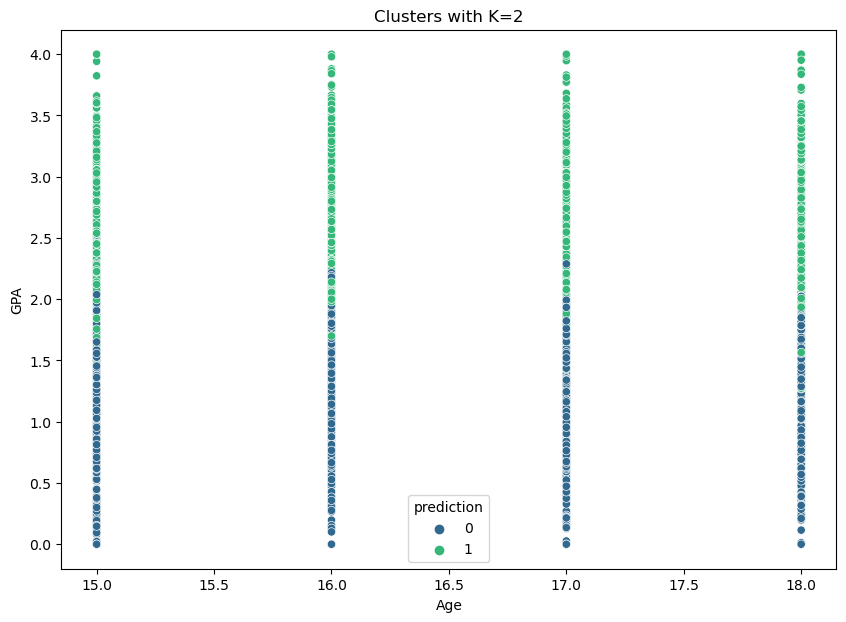

In [59]:
df_predict_best_pd = df_predict_best.toPandas()
plt.figure(figsize=(10, 7))
sns.scatterplot(x=df_predict_best_pd['Age'], y=df_predict_best_pd['GPA'], hue=df_predict_best_pd['prediction'], palette='viridis')
plt.title(f'Clusters with K={best_k}')
plt.show()

The plot shows students grouped into two clusters based on age and GPA, with colors indicating the clusters. It suggests that students can be categorized into two distinct groups, primarily based on GPA rather than age, since GPA is consistent across different ages. This visualization helps to understand **how the model categorized students but also indicates that age may not strongly influence GPA** in these clusters.

Some Questions:

* How does the model's performance vary with different numbers of clusters?
* What are the potential reasons for any misclassifications, and how might you address them?

***
***